<h1 class="alert alert-block alert-info" style="text-align:center; font-size:36px">Chess Visualization Project, Part 1</h1>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> This is Part 1 of my two part series for visualizing chess data. In this notebook, I take unpolished chess portable game notation (PGN) and convert it into a readable CSV with essential features. I take the CSV I create here and perform different analyses and visualizations on the data in Part 2 of this notebook. </p> 
    
<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px">Note: I am using an August 2014 version of the database because other versions are far too large. This version does not have many of the features future versions have (e.g. Rapid mode, variant chess), which also makes the data a bit easier to deal with. The foundation of this code is definitely appliable to newer versions of the database though. Below is a graph that shows just how much more popular chess has become recently.</p>

In [1]:
from bs4 import BeautifulSoup as soup
from urllib.request import Request, urlopen
from matplotlib import dates
from datetime import datetime
from dateutil.relativedelta import *

# Web scraping

fname = 'https://database.lichess.org/'
req = Request(fname, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req)
page_soup = soup(webpage, "html.parser")
containers = page_soup.findAll("tr")

new_containers = []
for container in containers:
    if str(container).find('standard') != -1:
        new_containers.append(container)
        
num_games_list = []
for i in range(len(new_containers)-1, -1, -1):
    c = new_containers[i].findAll("td")
    num = int(c[2].text.replace(',', ''))
    num_games_list.append(num)
    
# Create date tickers

date_list = []
start_date = datetime(2013, 1, 1)
for x in range(len(new_containers)):
    date_list.append(start_date)
    start_date += relativedelta(months=1)

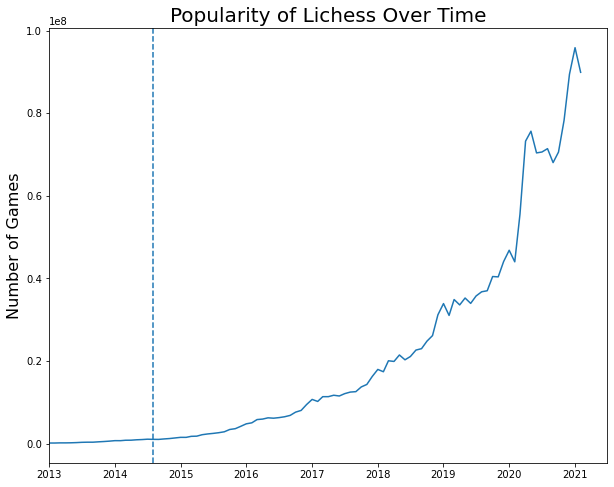

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data=num_games_list, columns=['Number'])
df.index = date_list
plt.figure(figsize=(10, 8))
plt.plot(df)
plt.title("Popularity of Lichess Over Time", fontsize=20)
plt.ylabel("Number of Games", fontsize=16)
plt.axvline(datetime(2014, 8, 1), linestyle='--')
plt.xlim(datetime(2013, 1, 1))
plt.show()

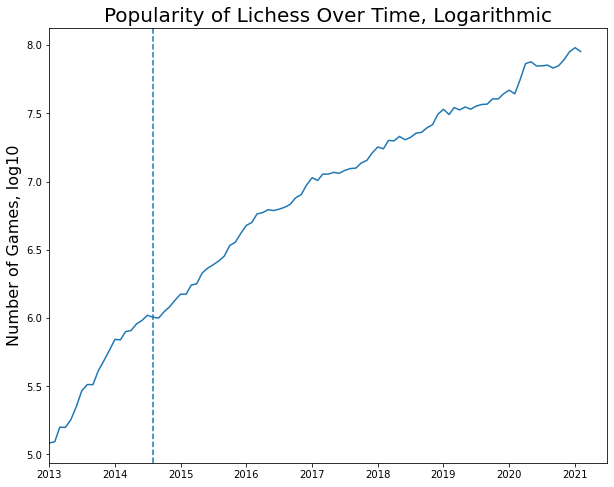

In [3]:
import numpy as np

df = pd.DataFrame(data=np.log10(num_games_list), columns=['Number'])
df.index = date_list
plt.figure(figsize=(10, 8))
plt.plot(df)
plt.title("Popularity of Lichess Over Time, Logarithmic", fontsize=20)
plt.ylabel("Number of Games, log10", fontsize=16)
plt.axvline(datetime(2014, 8, 1), linestyle='--')
plt.xlim(datetime(2013, 1, 1))
plt.show()

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">Included in these graphs is a dashed line which represents the number of games in the August 2014 database I use for this notebook.</p>

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="imports"> Reading the Raw Data / Essential Imports <a class="anchor-link" href="https://www.kaggle.com/ironicninja/converting-raw-chess-pgn-to-readable-data/notebook#imports">¶</a> </h1>

In [4]:
import bz2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [5]:
with bz2.open("/kaggle/input/raw-chess-games-pgn/lichess_db_standard_rated_2014-08.pgn.bz2", "rb") as f:
    data = f.read()

In [6]:
data = str(data) # Convert binary data into string for easier functionality
raw_games = data.split('[Event') # Split the data into chess games using the '[Event' string
print("Game at 0th index: %s" % raw_games[0])
del raw_games[0] # The first index isn't a game
del data # Remove binary string to save memory

Game at 0th index: b'


<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id ="EDA">Exploratory Data Analysis (EDA) <a class="anchor-link" href="https://www.kaggle.com/ironicninja/converting-raw-chess-pgn-to-readable-data/notebook#EDA">¶</a> </h1>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> In this dataset, there are three types of games: "normal" games (consistent with PGN), games with analysis (i.e., there is 'eval' attached which an engine's evaluation of the position), and empty games (no moves were played at all). Below, I give an example of each of these types of games. </p>

In [7]:
analysis_games = 0
empty_games = 0

print("Sample normal game: %s\n" % raw_games[0])
for game in raw_games:
    if game.find('eval') != -1:
        if analysis_games == 0:
            print("Sample game with analysis attached: %s\n" % game)
        analysis_games += 1

for game in raw_games:
    if game.find('1.') == -1:
        if empty_games == 0:
            print("Sample empty game: %s" % game)
        empty_games += 1

Sample normal game:  "Rated Classical game"]\n[Site "https://lichess.org/Gg06eUOY"]\n[White "rima65"]\n[Black "aywee"]\n[Result "0-1"]\n[UTCDate "2014.07.31"]\n[UTCTime "22:00:00"]\n[WhiteElo "1407"]\n[BlackElo "1669"]\n[WhiteRatingDiff "-5"]\n[BlackRatingDiff "+5"]\n[ECO "B06"]\n[Opening "Robatsch (Modern) Defense"]\n[TimeControl "420+8"]\n[Termination "Time forfeit"]\n\n1. e4 g6 2. d4 Bg7 3. c3 d6 4. Qf3 Nf6 5. h3 O-O 6. Bg5 Nbd7 7. Bc4 a6 8. h4 b5 9. Bd5 Nxd5 10. exd5 Bb7 11. h5 Nf6 12. h6 Bh8 13. Bxf6 Bxf6 14. Nd2 Qd7 15. Qh3 Qxh3 16. Rxh3 Bxd5 17. g4 Be6 18. Rg3 Bh4 19. Rg2 f5 20. Ngf3 Bf6 21. g5 Bh8 22. Nh4 c5 23. Rh2 cxd4 24. cxd4 Bxd4 25. Nxg6 hxg6 26. h7+ Kh8 27. Nf3 Bxb2 28. Rb1 Bc3+ 29. Kf1 Rf7 30. Nh4 Rg7 31. Nf3 Rxh7 32. Rxh7+ Kxh7 33. Rc1 b4 34. Ke2 Bxa2 35. Nd2 Kg7 36. Nf3 e5 37. Nh4 a5 38. Rd1 Bc4+ 39. Ke3 d5 40. Nf3 a4 41. Nd2 Bxd2+ 0-1\n\n

Sample game with analysis attached:  "Rated Bullet game"]\n[Site "https://lichess.org/s3CHmrgH"]\n[White "JekyllHyde"]\n[Black "M

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> I create a pie chart here to visualize the amount of different types of games there are in this raw dataset.</p>

Number of total games: 1013294
Number of normal games: 843230
Number of games with eval attached: 169854
Number of empty games: 210


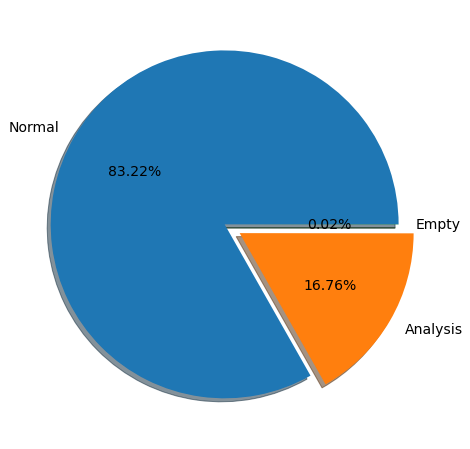

In [8]:
normal_games = len(raw_games)-analysis_games-empty_games

print("Number of total games: %d" % len(raw_games))
print("Number of normal games: %d" % normal_games)
print("Number of games with eval attached: %d" % analysis_games)
print("Number of empty games: %d" % empty_games)

explode = [0, 0.1, 0]
plt.figure(figsize=(12, 8))
labels = ['Normal', 'Analysis', 'Empty']
pie_data = [normal_games/len(raw_games), analysis_games/len(raw_games), empty_games/len(raw_games)]
plt.pie(pie_data, labels=labels, autopct='%1.2f%%', shadow=True, explode=explode, textprops={'fontsize': 14})
plt.show()

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="cleaning">Cleaning the Data <a class="anchor-link" href="https://www.kaggle.com/ironicninja/converting-raw-chess-pgn-to-readable-data/notebook#cleaning">¶</a> </h1>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> The games that are not consistent with normal PGN notation can cause bugs in the code. Therefore, in this section, I remove the games that are empty or have analysis through a brute force approach. </p>

In [9]:
all_games = []
for i in range(len(raw_games)):
    if raw_games[i].find('eval') != -1 or raw_games[i].find('1.') == -1:
        continue
    else:
        all_games.append(raw_games[i])

del raw_games # remove old uncleaned version to save memory

In [10]:
len(all_games)

843230

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="convert">Converting the Data into a Pandas Dataframe <a class="anchor-link" href="https://www.kaggle.com/ironicninja/converting-raw-chess-pgn-to-readable-data/notebook#convert">¶</a> </h1>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> In this section, I convert the raw data I have into a pandas dataframe, so that later it can be transformed into a readable CSV file. My algorithms search through the strings and are able to generate essential features from it. I'm not sure if the bz2 data can be converted to JSON or be converted directly to a dictionary, but if it could, it would make the process of feature engineering much easier. </p>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> If you're interested, I've included a naive method of extracting games with the eval bar in a notebook linked here: <a href="https://www.kaggle.com/ironicninja/method-for-extracting-games-with-eval-bar"> Method for Extracting Games with Eval Bar</a>. I opted not to include the method here since A. I'm not using it and B. I don't want to confuse the reader. </p>

In [11]:
%%time
PGN_list = []
mode_list = []
result_list = []
avg_rating_list = []
rating_diff_list = []
termination_list = []
for game in all_games:
    # PGN
    index = game.find("1. ") + 2
    while True:
        if game[index:index+2] == '0-' or game[index:index+2] == '1-' or game[index:index+2] == '1/':
            # Game termination
            break
        index += 1
    
    PGN_list.append(game[game.find("1."):index-1])
    
    # Mode
    index = game.find("d") + 2
    s = ""
    while True:
        if game[index] == " ":
            break
        s += game[index]
        index += 1
    mode_list.append(s)
    
    # Result
    index = game.find('Result')+8
    result = game[index:index+2]
    if result == "1-":
        result_list.append("White Wins")
    elif result == "0-":
        result_list.append("Black Wins")
    elif result == "1/":
        result_list.append("Draw")
    
    # Rating
    wIndex = game.find('WhiteElo') + 10
    bIndex = game.find('BlackElo') + 10
    wString = ""
    while True:
        # Use a loop in case there's a rating <1000
        if game[wIndex] == '"':
            break
        wString += game[wIndex]
        wIndex += 1
    
    bString = ""
    while True:
        if game[bIndex] == '"':
            break
        bString += game[bIndex]
        bIndex += 1
        
    wRating = int(wString)
    bRating = int(bString)
    avg_rating_list.append(math.ceil((wRating+bRating)/2))
    rating_diff_list.append(wRating-bRating)
    
    # Termination
    index = game.find("[Termination")
    quotes = 0
    s = ""
    while quotes < 2:
        if game[index] == '"':
            quotes += 1
        elif quotes == 1:
            s += game[index]
        index += 1
    
    termination_list.append(s)

CPU times: user 4min 51s, sys: 2.27 s, total: 4min 53s
Wall time: 4min 53s


In [12]:
chess_df = pd.DataFrame({})
chess_df['PGN'] = PGN_list
chess_df['Mode'] = mode_list
chess_df['Result'] = result_list
chess_df['Average Rating'] = avg_rating_list
chess_df['Rating Difference'] = rating_diff_list
chess_df['Termination Type'] = termination_list

In [13]:
chess_df.head()

,PGN,Mode,Result,Average Rating,Rating Difference,Termination Type
0,1. e4 g6 2. d4 Bg7 3. c3 d6 4. Qf3 Nf6 5. h3 O...,Classical,Black Wins,1538,-262,Time forfeit
1,1. d4 Nf6 2. c4 g6 3. a3 Bg7 4. Nf3 O-O 5. Nc3...,Blitz,Black Wins,1492,-220,Time forfeit
2,1. e4 c5 2. Qf3 e5 3. Bc4 Nf6 4. Nh3 h6 5. g4 ...,Blitz,White Wins,1413,213,Normal
3,1. e4 e5 2. Nf3 d6 3. Nc3 f5 4. exf5 Bxf5 5. d...,Blitz,Black Wins,1444,-358,Normal
4,1. e4 e6 2. d4 d5 3. Nc3 Nf6 4. e5 Ne4 5. Nce2...,Bullet,White Wins,1931,117,Normal


In [14]:
print("Dataset is %.2f MB" % (chess_df.memory_usage(deep=True).sum()/1000000))

Dataset is 565.14 MB


In [15]:
print("Original array length: %d\nNew dataframe length: %d" % (len(all_games), len(chess_df)))

Original array length: 843230
New dataframe length: 843230


In [16]:
EXPORT = True

if EXPORT:
    chess_df.to_csv("lichess-08-2014.csv", index=True, header=True)